In [102]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import json
import os
import py_vncorenlp
from underthesea import sent_tokenize
import numpy as np
from rank_bm25 import BM25Okapi
from numpy.random import normal
from scipy.stats import truncnorm, boxcox, gamma
import matplotlib.pyplot as plt

import os, sys
sys.path.append("../src")

from sentences_selection import select_sentences
import copy

In [2]:
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=os.path.abspath('../vncorenlp'))

2023-10-25 16:06:10 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

In [4]:
import re
def no_accent_vietnamese(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

def sentences_splitting(text, rdrsegmenter=rdrsegmenter):

    text_lower = no_accent_vietnamese(text.lower())
    
    original_sents=[]
    processed_sents = []
    
    text_pos = 0
    for _, sent in rdrsegmenter.annotate_text(text).items():
        words = [w["wordForm"] for w in sent]
        words = [w.replace("_", " ") if w != "_" else "_" for w in words]

        processed_sents.append(" ".join(words))

        words = [no_accent_vietnamese(w.lower()) for w in words]
        words = sum([w.split() for w in words],[])


        # find position of words in text_lower
        pos_start = []
        pos_end = []

        for w in words:
            idx = text_lower.find(w,text_pos)

            pos_start.append(idx)
            pos_end.append(idx + len(w))

            text_pos = idx + len(w)
        
        # for testing
        # test = [text_lower[pos_start[i]: pos_end[i]] for i in range(len(pos_start))]
        # assert test == words

        original_sents.append(text[pos_start[0]: pos_end[-1]])
    return original_sents, processed_sents


In [5]:
data = pd.read_json("../datasets/ise-dsc01-public-test-offcial.json", orient="index")

In [6]:
idx = 29706

In [7]:
data.sample(n=1).reset_index().loc[0]

index                                                  47420
context    Cầy mangut vằn lớn cỡ con mèo, chỉ dài khoảng ...
claim      Tuy nhiên, cầy đực không thể giao chiến trong ...
Name: 0, dtype: object

In [1360]:
idx = 29706
sample = data.sample(n=1).reset_index().loc[0]
text = sample["context"]
claim = sample["claim"]
context = rdrsegmenter.word_segment(text)

In [1361]:
def clean_str(s):
    return ''.join(e.lower() if e.isalnum() else " " for e in s)

In [1362]:
query = no_accent_vietnamese(clean_str(claim)).split()
query

['an',
 'da',
 'nhan',
 'bang',
 'cu',
 'nhan',
 'khoa',
 'hoc',
 'du',
 'lieu',
 'vao',
 'thang',
 '10',
 '2022']

In [1363]:
[no_accent_vietnamese(clean_str(doc)) for doc in context]

['nam 2015   sau khi tot nghiep truong thpt chuyen le hong phong   tp hcm   vo nguyen an   sinh nam 1997   quyet dinh   gap year   mot nam de chuan bi ho so   tieng anh va du lich truoc khi di du hoc  ',
 'uoc mo cua an la den nuoc my hoc nganh co khi   theo duoi so thich lap rap oto  ',
 'thang 4 2016   an trung tuyen dai hoc virginia tech o blacksburg   bang virginia  ',
 'truong khong cap hoc bong nen bo me phai chu cap cho an moi nam khoang 45 000 usd   hon 1 ty dong   de con trai theo duoi dam me  ',
 '  ba phai lam cong viec ba khong thich de kiem du tien cho con di hoc   de sau nay con co the lam duoc cong viec ma con thich     cau noi cua bo theo an tu viet nam sang my   la dong luc de chang trai tre co gang hoc tap  ',
 'tuy nhien   trong nam dau tien   ket qua hoc cua an khong duoc nhu mong muon  ',
 'nhu nhieu du hoc sinh khac   nam sinh gap rao can ve ngon ngu va van hoa  ',
 'de thich nghi   an chu dong giao tiep va ket ban voi nguoi ban xu   luyen ky nang nghe noi va ung 

In [1364]:
bm25 = BM25Okapi([no_accent_vietnamese(clean_str(doc)).split() for doc in context])

In [1365]:
query_score = bm25.get_scores(query=query)
query_score

array([ 3.5447328 ,  1.96049534,  7.22171211,  1.60436866,  2.84866996,
        2.08682798,  3.35628506,  0.74855655,  2.2890305 ,  6.71928256,
        5.5938067 , 14.67577541,  3.52841752,  2.4048752 ,  4.33111397,
        2.11137764,  3.46684112,  2.88371436,  7.10141328,  2.91514342,
        2.52203852,  0.80897816,  8.23935092,  2.68019986,  2.24140181,
        0.        ,  0.        ,  0.79297639,  0.64086014,  0.92041903,
        5.88881423,  0.        ,  0.        ,  0.74855655,  0.77759539,
        2.25100816,  4.79358885,  3.34562905,  2.76663277,  0.        ,
        0.92041903,  0.77759539,  1.00502579,  5.35771844,  0.        ,
        0.        ,  0.        ,  0.        ,  0.84300061,  2.66331453,
        3.08544725,  5.67635252,  1.63130769,  0.        ])

In [1366]:
def distribute_score(score, arr_len, pos):
    if arr_len == 1:
        return [score]
    myclip_a = 0
    myclip_b = 1
    my_mean = pos/(arr_len - 1)
    my_std = 0.65 / arr_len
    
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    x_range = np.linspace(0,1,arr_len)

    y = truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std)

    return score*y/sum(y)
    

In [1367]:
# final_doc_scores = np.zeros(len(query_score))

final_doc_scores = sum([distribute_score(score,len(query_score), idx) for idx, score in enumerate(query_score)])
sorted_ids = sorted(range(len(context)), key=lambda k: final_doc_scores[k], reverse=True)

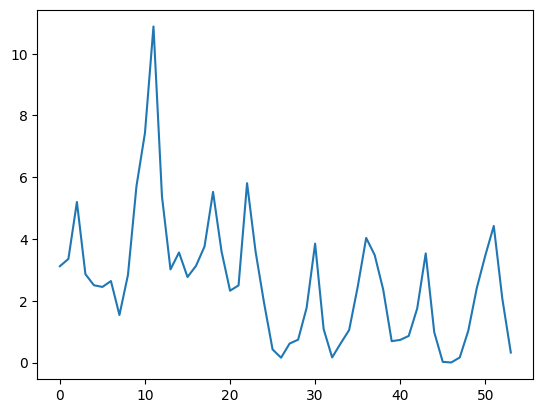

In [1368]:
x = range(len(context))

plt.plot(x, final_doc_scores)

In [1369]:
claim

'an đã nhận bằng cử nhân khoa học dữ liệu vào tháng 10/2022'

In [1370]:
[context[i] for i in sorted_ids]

['Tháng 5/2021 , An nhận bằng cử_nhân Khoa_học_Kỹ_thuật Cơ_khí , chuyên_ngành Cơ_khí ôtô với điểm GPA 3.62/4.0 , nằm trong top 10% sinh_viên điểm_cao của trường .',
 'Cùng với niềm đam_mê lĩnh_vực cơ_khí và tập_trung cao_độ vào việc học , từ năm thứ hai , dù có nhiều môn chuyên_ngành khó , việc học của An trở_nên dễ_dàng hơn .',
 'Tháng 2/2022 , An trở_thành kỹ_sư bậc 1 , chuyên thiết_kế robot để kiểm_tra các thông_số trong lò phản_ứng hạt_nhân .',
 'Nam_sinh cũng nhận ra dù chỉ thuộc diện " khá " ở Việt_Nam nhưng nền_tảng về các môn khoa_học_tự_nhiên là điểm mạnh của em so với nhiều sinh_viên khác .',
 'Tháng 3/2021 , chàng trai nhận được lời mời làm_việc chính_thức từ Framatome , công_ty kinh_doanh lò phản_ứng hạt_nhân của Pháp có chi_nhánh tại Mỹ và gia_nhập vào tháng 7 cùng năm .',
 'Trong thời_gian học , để làm_quen với thị_trường lao_động Mỹ , An ứng_tuyển và trúng vị_trí thực_tập_sinh thiết_kế bảng vẽ 2D tại một công_ty về điện khi đang học năm thứ hai .',
 'Tháng 4/2016 , An tr

In [1371]:
model_max_length = 256
claim_tk_length = len(tokenizer(claim).input_ids[:-1])
abstract_len = model_max_length - claim_tk_length - 1
context_tk_length = [len(tokenizer(s).input_ids[:-1]) for s in context]

In [1372]:
fin_len = 0
mask = [0 for _ in range(len(sorted_ids))]
for i in sorted_ids:
    if fin_len + context_tk_length[i] > abstract_len:
        break
    
    fin_len += context_tk_length[i]
    mask[i] = 1

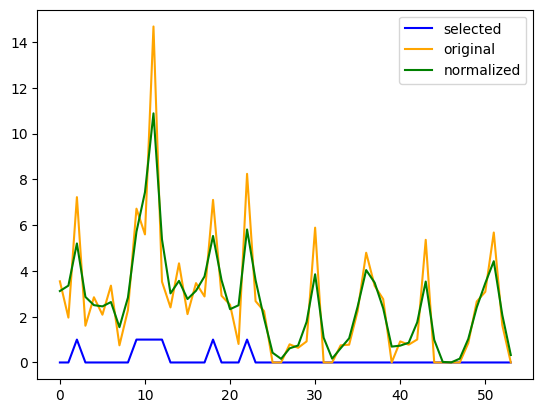

In [1373]:
plt.plot(x, mask,color="blue", label="selected")
# original
plt.plot(x, query_score,color="orange",label="original")
# normalized
plt.plot(x, final_doc_scores,color="green", label="normalized")
plt.legend(loc='best')
plt.show()

In [1374]:
[context[i] for i in range(len(context)) if mask[i] == 1]

['Tháng 4/2016 , An trúng_tuyển Đại_học Virginia_Tech ở Blacksburg , bang Virginia .',
 'Nam_sinh cũng nhận ra dù chỉ thuộc diện " khá " ở Việt_Nam nhưng nền_tảng về các môn khoa_học_tự_nhiên là điểm mạnh của em so với nhiều sinh_viên khác .',
 'Cùng với niềm đam_mê lĩnh_vực cơ_khí và tập_trung cao_độ vào việc học , từ năm thứ hai , dù có nhiều môn chuyên_ngành khó , việc học của An trở_nên dễ_dàng hơn .',
 'Tháng 5/2021 , An nhận bằng cử_nhân Khoa_học_Kỹ_thuật Cơ_khí , chuyên_ngành Cơ_khí ôtô với điểm GPA 3.62/4.0 , nằm trong top 10% sinh_viên điểm_cao của trường .',
 'Trong thời_gian học , để làm_quen với thị_trường lao_động Mỹ , An ứng_tuyển và trúng vị_trí thực_tập_sinh thiết_kế bảng vẽ 2D tại một công_ty về điện khi đang học năm thứ hai .',
 'Tháng 3/2021 , chàng trai nhận được lời mời làm_việc chính_thức từ Framatome , công_ty kinh_doanh lò phản_ứng hạt_nhân của Pháp có chi_nhánh tại Mỹ và gia_nhập vào tháng 7 cùng năm .',
 'Tháng 2/2022 , An trở_thành kỹ_sư bậc 1 , chuyên thiết_

In [1375]:
claim

'an đã nhận bằng cử nhân khoa học dữ liệu vào tháng 10/2022'

# context slicing
slicing a single context into multiple smaller context 

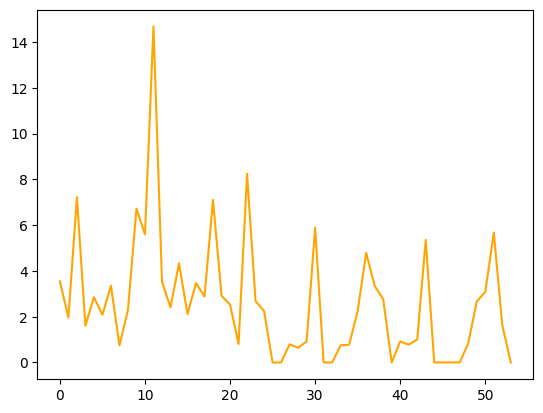

In [1376]:
plt.plot(x, query_score,color="orange",label="original")
plt.show()

In [1377]:
context_tk_length


[43,
 17,
 16,
 28,
 49,
 16,
 14,
 20,
 20,
 31,
 34,
 32,
 34,
 33,
 36,
 30,
 16,
 42,
 38,
 20,
 29,
 21,
 23,
 15,
 36,
 27,
 21,
 17,
 33,
 14,
 12,
 15,
 12,
 26,
 19,
 16,
 35,
 21,
 20,
 11,
 16,
 20,
 24,
 20,
 13,
 6,
 27,
 14,
 18,
 21,
 21,
 60,
 33,
 2]

In [1378]:
def get_longest_continuest_context(tokenized_sents_lenght, start_pos, max_token_number):
    if start_pos >= len(tokenized_sents_lenght):
        return [], 0
    selected = []
    curr_length = 0
    for idx in range(start_pos, len(tokenized_sents_lenght)):
        if curr_length + tokenized_sents_lenght[idx] > max_token_number:
            break
        selected.append(idx)
        curr_length += tokenized_sents_lenght[idx]
    
    return selected, curr_length

In [1379]:
best_context = []
max_score = 0
for i in range(len(context_tk_length)):
    selected, curr_length = get_longest_continuest_context(context_tk_length, start_pos=i, max_token_number=200)
    score = sum([query_score[i] for i in selected])
    if score > max_score:
        best_context = selected
        max_score = score
    print(selected, score)
print(best_context, max_score)

[0, 1, 2, 3, 4, 5, 6] 22.62309190958011
[1, 2, 3, 4, 5, 6, 7, 8] 22.115946162102098
[2, 3, 4, 5, 6, 7, 8, 9] 26.87473338506115
[3, 4, 5, 6, 7, 8, 9] 19.653021276645553
[4, 5, 6, 7, 8, 9, 10] 23.642459317661313
[5, 6, 7, 8, 9, 10, 11] 35.46956476767569
[6, 7, 8, 9, 10, 11, 12] 36.911154310930215
[7, 8, 9, 10, 11, 12] 33.55486924646258
[8, 9, 10, 11, 12, 13] 35.2111878963006
[9, 10, 11, 12, 13, 14] 37.25327136668194
[10, 11, 12, 13, 14, 15] 32.645366442828475
[11, 12, 13, 14, 15, 16] 30.51840086225203
[12, 13, 14, 15, 16, 17] 18.726339814068375
[13, 14, 15, 16, 17, 18] 22.299335576482292
[14, 15, 16, 17, 18, 19] 22.809603792702863
[15, 16, 17, 18, 19, 20, 21] 21.809506500803177
[16, 17, 18, 19, 20, 21, 22] 27.93747978359744
[17, 18, 19, 20, 21, 22, 23] 27.150838520829495
[18, 19, 20, 21, 22, 23, 24] 26.508525973513525
[19, 20, 21, 22, 23, 24, 25, 26] 19.40711269276781
[20, 21, 22, 23, 24, 25, 26, 27] 17.28494566620029
[21, 22, 23, 24, 25, 26, 27, 28] 15.403767291255315
[22, 23, 24, 25, 2

In [1380]:
def get_best_continuest_context(tokenized_sents_lenght, query_score, max_token_number=200):
    best_context = []
    max_score = 0
    for i in range(len(tokenized_sents_lenght)):
        selected, curr_length = get_longest_continuest_context(tokenized_sents_lenght, start_pos=i, max_token_number=max_token_number)
        score = sum([query_score[i] for i in selected])
        if score > max_score:
            best_context = selected
            max_score = score
    return best_context, max_score

In [1381]:
best_context, max_score = get_best_continuest_context(
    tokenized_sents_lenght=context_tk_length,
    query_score=query_score
)

print([context[i] for i in best_context])

['Nam_sinh cũng nhận ra dù chỉ thuộc diện " khá " ở Việt_Nam nhưng nền_tảng về các môn khoa_học_tự_nhiên là điểm mạnh của em so với nhiều sinh_viên khác .', 'Cùng với niềm đam_mê lĩnh_vực cơ_khí và tập_trung cao_độ vào việc học , từ năm thứ hai , dù có nhiều môn chuyên_ngành khó , việc học của An trở_nên dễ_dàng hơn .', 'Tháng 5/2021 , An nhận bằng cử_nhân Khoa_học_Kỹ_thuật Cơ_khí , chuyên_ngành Cơ_khí ôtô với điểm GPA 3.62/4.0 , nằm trong top 10% sinh_viên điểm_cao của trường .', 'Trong thời_gian học , để làm_quen với thị_trường lao_động Mỹ , An ứng_tuyển và trúng vị_trí thực_tập_sinh thiết_kế bảng vẽ 2D tại một công_ty về điện khi đang học năm thứ hai .', 'Năm tiếp_theo , An nộp đơn ứng_tuyển thực_tập đến gần 50 công_ty và được nhận làm thực_tập_sinh ở hãng xe Volvo_Trucks khu_vực Bắc_Mỹ trong vai_trò kỹ_sư bán hàng .', 'An nhớ lại , mỗi tuần công_ty này nhận khoảng 10.000 đơn đặt_hàng sản_xuất xe ôtô tải , xe đầu kéo_theo yêu_cầu của khách nên thường_xuyên trong tình_trạng quá_tải ,

In [1382]:
def slice_context(tokenized_sents_lenght, number_of_contexts, query_score, max_token_number=200):
    qscores = copy.copy(query_score)
    selected = []

    for _ in range(number_of_contexts):
        best_context, max_score = get_best_continuest_context(
            tokenized_sents_lenght=context_tk_length,
            query_score=qscores,
            max_token_number=max_token_number
        )
        
        # reduce the score of the selected context

        for i in best_context:
            qscores[i] /= 4
        print(max_score)
        if best_context not in selected:
            selected.append(best_context)
    return selected

In [1383]:
query_score

array([ 3.5447328 ,  1.96049534,  7.22171211,  1.60436866,  2.84866996,
        2.08682798,  3.35628506,  0.74855655,  2.2890305 ,  6.71928256,
        5.5938067 , 14.67577541,  3.52841752,  2.4048752 ,  4.33111397,
        2.11137764,  3.46684112,  2.88371436,  7.10141328,  2.91514342,
        2.52203852,  0.80897816,  8.23935092,  2.68019986,  2.24140181,
        0.        ,  0.        ,  0.79297639,  0.64086014,  0.92041903,
        5.88881423,  0.        ,  0.        ,  0.74855655,  0.77759539,
        2.25100816,  4.79358885,  3.34562905,  2.76663277,  0.        ,
        0.92041903,  0.77759539,  1.00502579,  5.35771844,  0.        ,
        0.        ,  0.        ,  0.        ,  0.84300061,  2.66331453,
        3.08544725,  5.67635252,  1.63130769,  0.        ])

In [1384]:
sum(context_tk_length)/200

6.435

In [1385]:
res = slice_context(
    tokenized_sents_lenght=context_tk_length,
    number_of_contexts = sum(context_tk_length)//240 + 1,
    query_score=query_score
)
res

37.25327136668194
27.93747978359744
22.62309190958011
21.492244025160833
17.62583335299436
11.505978866150631
10.31833274984503


[[9, 10, 11, 12, 13, 14],
 [16, 17, 18, 19, 20, 21, 22],
 [0, 1, 2, 3, 4, 5, 6],
 [29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
 [43, 44, 45, 46, 47, 48, 49, 50, 51],
 [6, 7, 8, 9, 10, 11, 12],
 [18, 19, 20, 21, 22, 23, 24]]

In [1386]:
res[0]

[9, 10, 11, 12, 13, 14]

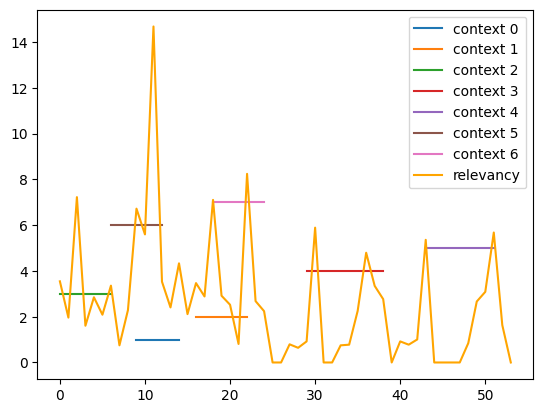

In [1387]:

for idx,sl in enumerate(res):
    plt.plot(sl, [1 + idx for _ in range(len(sl))], label="context " + str(idx))
plt.plot(x, query_score,color="orange",label="relevancy")
plt.legend(loc='best')

plt.show()
